Simulation of arbitrary transfer functions
------------------------------------------

In [1]:
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

We are very familiar with the Euler integration method by now. Let's recap a quick simulation of a first-order system

$$G = \frac{y(s)}{u(s)} = \frac{K}{\tau s + 1}$$

We can rewrite this in the time domain as

$$ y(s) (\tau s + 1) = K u(s) $$

$$ \tau \frac{dy}{dt} + y(t) = K u(t) $$

$$ \frac{dy}{dt} = -\frac{1}{\tau}y(t) + \frac{K}{\tau}u(t)$$

In [2]:
K = 1
tau = 5

In [3]:
def u(t):
    if t<1:
        return 0
    else:
        return 1

In [4]:
ts = numpy.linspace(0, 20, 1000)
dt = ts[1]
y = 0
ys = []
for t in ts:
    dydt = -1/tau*y + 1/tau*u(t)
    
    y += dydt*dt
    ys.append(y)

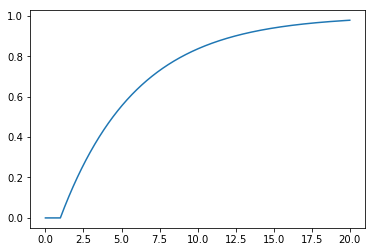

In [5]:
plt.plot(ts, ys)

Notice in the previous code that all the differential equations were linear and that that none of the coefficients of the variables change over time. Such a system is known as a Linear, Time Invariant (LTI) system. The `scipy.signal` module supplies many functions for dealing with LTI systems

In [6]:
import scipy.signal

We define an LTI system by passing the coefficients of the numerator and denominator to the `lti` constructor

In [7]:
numerator = K
denominator = [tau, 1]
G = scipy.signal.ltisys.TransferFunction(numerator, denominator)

In [8]:
G

TransferFunctionContinuous(
array([ 0.2]),
array([ 1. ,  0.2]),
dt: None
)

We can obtain the step response of the system by using the `step` method of the object

In [9]:
def plotstep(G):
    _, ys_step = G.step(T=ts)
    plt.plot(ts, ys_step);

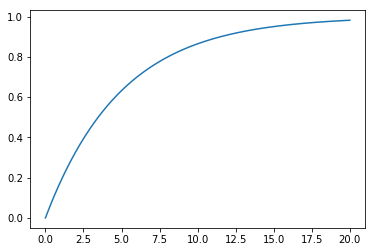

In [10]:
plotstep(G)

We can also find the response of the system to an arbitrary input signal by using `scipy.signal.lsim()`

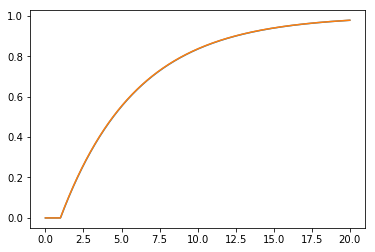

In [11]:
us = [u(t) for t in ts]  # evaluate the input function at all the times
_, ys_lsim, xs = scipy.signal.lsim(G, U=us, T=ts)
plt.plot(ts, ys_lsim, ts, ys);

We can also use our Euler loop to simulate arbitrary systems using the state space representation

$$\begin{align} \dot{x} &= Ax + Bu \\ y &= Cx + Du \end{align} $$

Luckily the `lti` object we created earlier knows its state space representation.

In [12]:
x = numpy.matrix(numpy.zeros(G.A.shape[0]))
ys_statespace = []
for t in ts:
    xdot = G.A.dot(x) + G.B.dot(u(t))
    y = G.C.dot(x) +  G.D.dot(u(t))
    
    x += xdot*dt
    ys_statespace.append(y[0,0])

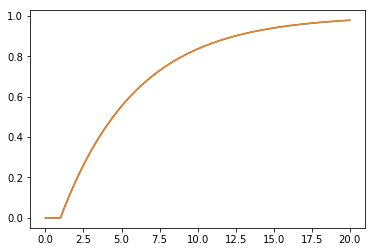

In [13]:
plt.plot(ts, ys,
         ts, ys_statespace);

# Higher order functions

This technique works for higher order functions, too. Let's find the step response of the following transfer function:

$$G_2 = \frac{1}{s^3 + 2s^2 + s + 1}$$

Feel free to uncomment and run the block below: I gave up waiting for the inverse to be calculated.

In [14]:
# import sympy

# s, t = sympy.symbols('s, t')
# G2 = 1/(s**3 + 2*s**2 + s + 1)
# r = sympy.inverse_laplace_transform(G2/s, s, t)

In [15]:
numerator = 1
denominator = [1, 2, 1, 1]
G2 = scipy.signal.ltisys.TransferFunction(numerator, denominator)

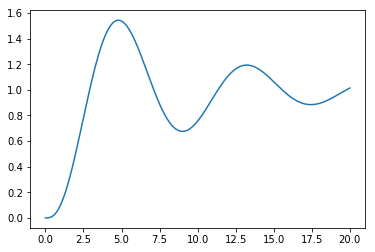

In [16]:
plotstep(G2)

## Systems in series

What if we wanted to see the response of $G_3(s) = G(s) G_2(s)$? You may expect that we would be able to find the product of two transfer functions, but the `scipy.signal` functions don't allow this.

In [17]:
G*G2

TypeError: unsupported operand type(s) for *: 'TransferFunctionContinuous' and 'TransferFunctionContinuous'

Instead, we could use the convolution of the numerators and the denominators. This is equivalent to polynomial multiplication. For instance, let's work out $(s + 1)^3$

In [19]:
numpy.convolve(numpy.convolve([1, 1], [1, 1]), [1, 1])

array([1, 3, 3, 1])

In [20]:
numerator = numpy.convolve(G.num, G2.num)
numerator

array([ 0.2])

In [21]:
denominator = numpy.convolve(G.den, G2.den)
denominator

array([ 1. ,  2.2,  1.4,  1.2,  0.2])

In [22]:
G3 = scipy.signal.ltisys.TransferFunction(numerator, denominator)

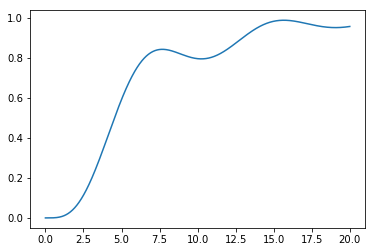

In [23]:
plotstep(G3)

# Control module

Another option is to use the [Python Control Systems Libaray](https://python-control.readthedocs.io/en/latest/). Unfortunately, this is not included in anaconda, so you will have to install it before use by uncommenting the line below and running it:

In [24]:
#!pip install control

In [25]:
import control

In [26]:
G = control.tf(K, [tau, 1])
G2 = control.tf(1, [1, 1, 1, 1])
G3 = G*G2

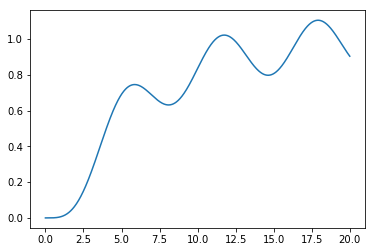

In [27]:
y, _ = control.step(G3, ts)
plt.plot(ts, y)